In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bayesian_pdes
import sympy as sp
import scipy.stats
%matplotlib inline
import time
import Cython
%load_ext Cython

In [2]:
ni = 18
nb = 9

In [3]:
x_1,x_2,y_1,y_2 = sp.symbols('x_1 x_2 y_1 y_2')
length_scale = 0.05
k = sp.exp(-((x_1-y_1)**2+(x_2-y_2)**2) / (2.*length_scale**2))
A = lambda f: sp.diff(f, x_1, x_1) + sp.diff(f, x_2, x_2)
Abar = lambda f: sp.diff(f, y_1, y_1) + sp.diff(f, y_2, y_2)
B = lambda f: f
Bbar = lambda f: f
symbols = [[x_1, x_2], [y_1, y_2]]

# interior observations: sin(x)*sin(y)
x_interior, y_interior = np.mgrid[0.1:0.9:ni*1j, 0.1:0.9:ni*1j]
interior = np.c_[x_interior.ravel(), y_interior.ravel()]
exterior = np.r_[
    np.c_[np.linspace(0.1,0.9,nb), np.zeros(nb)], 
    np.c_[np.linspace(0.1,0.9,nb), np.ones(nb)],
    np.c_[np.zeros(nb), np.linspace(0.1,0.9,nb)],
    np.c_[np.ones(nb), np.linspace(0.1,0.9,nb)]
]

interior_obs = np.sin(2*np.pi*interior[:,0]) + np.sin(2*np.pi*interior[:,1])
exterior_obs = np.r_[
    np.zeros(nb*2),
    np.zeros(nb*2)
]

print interior.shape, interior_obs.shape
print exterior.shape, exterior_obs.shape
#%lprun -f bayesian_pdes.collocation.calc_LLbar posterior = bayesian_pdes.collocate([A, B], [Abar, Bbar], k, symbols, [(interior, interior_obs), (exterior, exterior_obs)])

(324, 2) (324,)
(36, 2) (36,)


In [5]:
# set up the Allen-Cahn system
d = sp.Symbol('delta')
#d = 0.04
n_pts = 11

def A_1(delta):
    return lambda f: -delta*(sp.diff(f, x_1, x_1) + sp.diff(f, x_2, x_2)) - 1./delta * f

def A_1_bar(delta):
    return lambda f: -delta*(sp.diff(f, y_1, y_1) + sp.diff(f, y_2, y_2)) - 1./delta * f

Identity = lambda f: f
B = Identity

# for now collocate on a basic grid (this is not efficient)
x, y = np.mgrid[0:1:n_pts*1j, 0:1:n_pts*1j]
x = x.ravel(); y = y.ravel()

on_bdy = (x == 0.) | (x == 1.) | (y == 0.) | (y == 1.)

collocate_interior = np.c_[x[~on_bdy], y[~on_bdy]]

collocate_boundary = np.c_[x[on_bdy], y[on_bdy]]

# define what the RHS of the system looks like
def rhs(locations):
    return np.zeros(location.shape[0])

# and on the boundary...
def boundary_rhs(locations):
    ret = np.empty(locations.shape[0])
    # impose condition on the y boundary
    y_bdy = (locations[:,1] == 1) | (locations[:,1] == 0)
    ret[y_bdy] = -1
    # impose condition on the x boundary
    x_bdy = (locations[:,0] == 1) | (locations[:,0] == 0)
    ret[x_bdy] = 1
    
    if np.any(~(x_bdy | y_bdy)):
        missing = locations[~(x_bdy | y_bdy), :]
        raise Exception("Some boundary observations don't appear to be on the boundary: {}".format(missing))
    return ret

boundary_obs = boundary_rhs(collocate_boundary)

# Calculation of Importance Distn

In [6]:
from deflation.deflation import ForwardProblem
from deflation.petscsnessolver import PetscSnesSolver
import dolfin
from dolfin import dx
import math
import logging
logging.getLogger('FFC').setLevel(logging.WARNING)

In [7]:
# for ipython notebook
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def mesh2triang(mesh):
    xy = mesh.coordinates()
    return tri.Triangulation(xy[:, 0], xy[:, 1], mesh.cells())

def plot(obj):
    plt.gca().set_aspect('equal')
    if isinstance(obj, dolfin.Function):
        mesh = obj.function_space().mesh()
        if (mesh.geometry().dim() != 2):
            raise(AttributeError)
        if obj.vector().size() == mesh.num_cells():
            C = obj.vector().array()
            plt.tripcolor(mesh2triang(mesh), C)
        else:
            C = obj.compute_vertex_values(mesh)
            plt.tripcolor(mesh2triang(mesh), C, shading='gouraud')
    elif isinstance(obj, dolfin.Mesh):
        if (obj.geometry().dim() != 2):
            raise(AttributeError)
        plt.triplot(mesh2triang(obj), color='k')


In [8]:
import sys
args = [sys.argv[0]] + """
                       --petsc.snes_max_it 200
                       --petsc.snes_monitor
                       --petsc.snes_converged_reason
                       --petsc.snes_stol 0.0
                       --petsc.snes_rtol 0.0
                       --petsc.snes_type newtonls
                       --petsc.snes_linesearch_type basic

                       --petsc.ksp_type gmres
                       --petsc.ksp_rtol 1.0e-12
                       --petsc.ksp_atol 1.0e-12

                       --petsc.inner_pc_type lu
                       """.split()
dolfin.parameters.parse(argv=args)

In [9]:
def retry(fun, tries, success_condition=None, debug=True):
    for i in xrange(tries):
        try:
            res = fun()
        except Exception as ex:
            if debug: 
                print 'Attempt {} failed with exception {}'.format(i, ex)
            continue
        
        if success_condition is not None and success_condition(res):
            return res
        else:
            return res
        if debug:
            print 'Attempt {} failed'.format(i)
    raise Exception('Failed to find solution in {} tries'.format(tries))
    
meshes = {}
def find_solutions(delta, mesh_points, initial_guesses=None, max_solutions=3, stop_on_divergence=False, plot_solutions=False):
    # reuse mesh if we can
    if mesh_points in meshes:
        mesh = meshes[mesh_points]
    else:
        mesh = dolfin.UnitSquareMesh(mesh_points, mesh_points)
        size = dolfin.MPI.size(dolfin.mpi_comm_world())
        if size > 1:
            nrefine = math.log(size, 4)
            if int(nrefine) != nrefine:
                print "Need to have processors a power of 4, as each refinement multiplies work by 4"
                assert False

            for i in range(int(nrefine) + 3):
                mesh = dolfin.refine(mesh, redistribute=False)
        meshes[mesh_points] = mesh

    V = dolfin.FunctionSpace(mesh, "CG", 1)
    Vdim = V.dim()
    #if dolfin.MPI.rank(dolfin.mpi_comm_world()) == 0:
    #    print "Degrees of freedom: ", Vdim
    #    print "Degrees of freedom per core: ", Vdim/float(size)

    delta = dolfin.Constant(delta)

    u = dolfin.Function(V)

    v = dolfin.TestFunction(V)
    F = delta * dolfin.inner(dolfin.grad(v), dolfin.grad(u))*dx + 1.0/delta * dolfin.inner(v, u**3 - u)*dx

    bcs = [dolfin.DirichletBC(V, +1.0, "x[0] == 0.0 || x[0] == 1"),
           dolfin.DirichletBC(V, -1.0, "x[1] == 0.0 || x[1] == 1")]

    power = 1
    shift = 0.1
    problem = ForwardProblem(F, V, u, bcs, power=power, shift=shift)
    solver = PetscSnesSolver()

    roots = []
    natol = 1.0e-8

    for i in xrange(max_solutions):
        if initial_guesses is not None:
            u.assign(initial_guesses[i])
        dolfin.PETScOptions.set("snes_atol", natol)
        try:
            solver.solve(problem, u.vector())
        except Exception as ex:
            if stop_on_divergence:
                break
            else:
                raise
            
        roots.append(dolfin.Function(u, name="Solution"))

        if plot_solutions:
            plt.figure()
            plot(roots[-1])
            plt.colorbar()
            plt.show()

        u.assign(dolfin.Constant(0))
        problem.deflate(roots[-1])
        if shift > 0:
            natol *= shift
    return roots

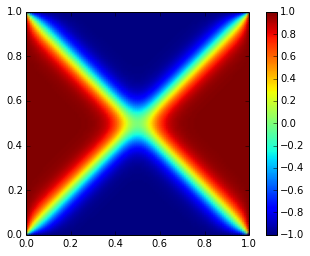

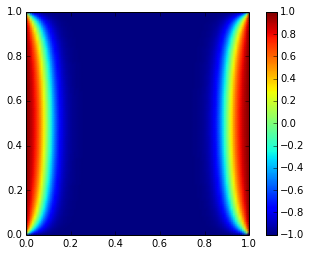

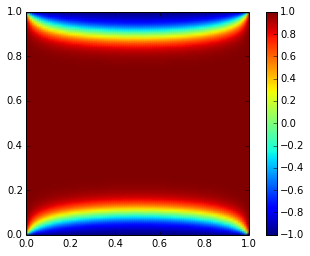

In [13]:
delta = 0.04
true_solutions = find_solutions(delta, 100, max_solutions=3, stop_on_divergence=False, plot_solutions=True)

In [14]:
true_solution_values = np.vectorize(true_solutions[0])(collocate_interior[:,0], collocate_interior[:,1])
true_obs = (collocate_interior, true_solution_values)

A sensible range looks like $\delta \in [0.035, 0.1]$. It looks (however) as though while it becomes difficult to find solutions after this point, the three-solution regime is not broken until closer to $\delta=0.2$

# Calculation of PN Probability

## Fast C version of operators

In [15]:
def log_likelihood(true_obs, solutions, likelihood_variance):
    true_locs, true_vals = true_obs
    dist = scipy.stats.multivariate_normal(true_vals, likelihood_variance)
    likelihoods = []
    for sol in solutions:
        solution_values = np.vectorize(sol)(true_locs[:,0], true_locs[:,1])
        likelihood = dist.logpdf(solution_values)
        likelihoods.append(likelihood)
    return np.max(likelihoods)
        

In [16]:
def nearest_known(value, known):
    known = np.array(known)
    return known[np.argmin(np.abs(known-value))]

In [17]:
# lastly put all of this together to sample from the delta distribution
known = {}
n_iter = 5000

delta_min = 0.035
delta_max = 0.1
def delta_prior(delta):
    
    if delta < delta_max and delta > delta_min:
        return 1./(delta_max-delta_min)
    return 0

#prev_delta = (delta_max + delta_min) / 2.
prev_delta = 0.04
delta_proposal_variance = 0.004
likelihood_variance = 0.05
deflation_grid_size = 25

#solutions_lambda = lambda delta: retry(lambda: find_solutions(delta, 50), 5, lambda s: len(s) == 3, True)
#print '  Generating solutions'
cur_solutions = find_solutions(prev_delta, deflation_grid_size)
known[prev_delta] = cur_solutions
#print '  Estimating p_pn ({} solutions)'.format(len(cur_solutions))
last_likelihood = log_likelihood(true_obs, cur_solutions, likelihood_variance)

prev_solutions = cur_solutions

samples = np.empty(n_iter)
acceptances = np.empty(n_iter, dtype=np.bool)
alphas = np.empty(n_iter)

for i in xrange(n_iter):
    start = time.time()
    dist = scipy.stats.norm(prev_delta, delta_proposal_variance)
    cur_delta = dist.rvs()
    print 'Iteration {} (delta {:.4f}->{:.4f})'.format(i, prev_delta, cur_delta)
    if cur_delta < delta_min or cur_delta > delta_max:
        # there is no way for the probability to be anything other than 0, so reject
        #print 'Rejected'
        samples[i] = prev_delta
        continue
    print '  Generating solutions',
    start2 = time.time()
    
    init_guess = known[nearest_known(cur_delta, known.keys())]
    try:
        cur_solutions = find_solutions(cur_delta, deflation_grid_size, initial_guesses=cur_solutions)
    except Exception as ex:
        # try starting from zero
        try:
            cur_solutions = find_solutions(cur_delta, deflation_grid_size)
        except Exception as ex:
            # try a finer mesh and adapting
            init_guess = find_solutions(cur_delta, 100)
            init_guess = [dolfin.interpolate(s, dolfin.FunctionSpace(meshes[deflation_grid_size], 'CG', 1))]
            # now try to solve on that initial guess
            cur_solutions = find_solutions(cur_delta, deflation_grid_size, initial_guesses=init_guess)
    known[cur_delta] = cur_solutions
    print '  (time taken {})'.format(time.time() - start2)
    p_cur_delta = dist.logpdf(cur_delta)
    print '  Estimating p_pn ({} solutions)'.format(len(cur_solutions)),
    start2 = time.time()
    likelihood = log_likelihood(true_obs, cur_solutions, likelihood_variance)
    print '  (time taken {})'.format(time.time() - start2)
    p_prior = delta_prior(cur_delta)
    
    p_prev_delta = dist.logpdf(prev_delta)
    p_prior_prev = delta_prior(prev_delta)
    
    alpha = np.exp(likelihood)/np.exp(last_likelihood) * np.exp(p_cur_delta-p_prev_delta) * p_prior / p_prior_prev
    
    print '  Alpha = {} (logp {}->{})'.format(alpha, last_likelihood, likelihood),
    accept = np.random.uniform() < min(alpha, 1)
    acceptances[i] = accept
    alphas[i] = alpha
    if accept:
        samples[i] = cur_delta
        prev_delta = cur_delta
        prev_solutions = cur_solutions
        last_likelihood = likelihood
        print (' (accepted)')
    else:
        samples[i] = prev_delta
        print (' (rejected)')
    print '  Total time {}'.format(time.time() - start)

Iteration 0 (delta 0.0400->0.0445)
  Generating solutions   (time taken 0.239034891129)
  Estimating p_pn (3 solutions)   (time taken 0.00337409973145)
  Alpha = 0.184837997041 (logp 46.8081886947->45.7420575502)  (rejected)
  Total time 0.244837999344
Iteration 1 (delta 0.0400->0.0466)
  Generating solutions   (time taken 0.206500053406)
  Estimating p_pn (3 solutions)   (time taken 0.00304102897644)
  Alpha = 0.0339855115737 (logp 46.8081886947->44.8011642839)  (rejected)
  Total time 0.211949110031
Iteration 2 (delta 0.0400->0.0421)
  Generating solutions   (time taken 0.442327022552)
  Estimating p_pn (3 solutions)   (time taken 0.00289297103882)
  Alpha = 0.613848571016 (logp 46.8081886947->46.4585202266)  (accepted)
  Total time 0.447813987732
Iteration 3 (delta 0.0421->0.0463)
  Generating solutions   (time taken 0.205580949783)
  Estimating p_pn (3 solutions)   (time taken 0.00290203094482)
  Alpha = 0.124970895311 (logp 46.4585202266->44.94079803)  (rejected)
  Total time 0.21

In [18]:
import pandas as pd

In [20]:
mcmc = pd.DataFrame({'Delta': samples[:i], 'Acceptances': acceptances[:i], 'Alpha': alphas[:i]})

In [22]:
mcmc.to_csv('mcmc_no_pn.csv')

0.592518503701
0.0393266693044


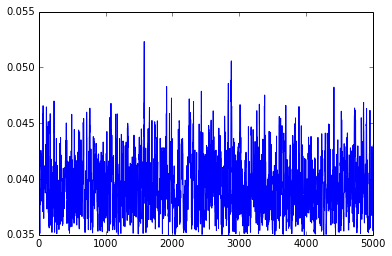

In [23]:
plt.plot(samples[:i])
print np.sum(acceptances[:i]) * 1./ i
print np.mean(samples[:i])

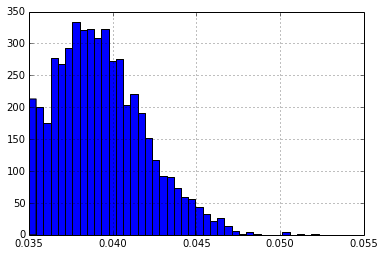

In [24]:
mcmc.Delta.hist(bins=40)

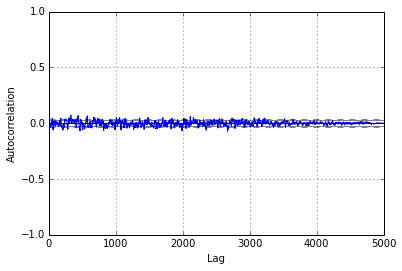

In [25]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(mcmc.Delta)